# Librerías

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import gc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Dataset

In [2]:


epoch = 4

class MyDataset_tv(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.samples = []
                
        for file_name in os.listdir(image_dir):
            if file_name.endswith('.jpg'):
                image_path = os.path.join(image_dir, file_name)
                # mask is in png format
                file_name = file_name.replace('.jpg', '.png')
                mask_path = os.path.join(mask_dir, file_name)
                sample = (image_path, mask_path)
                self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # L:SC, RGB:RGB 

        # image = np.array(image)
        # mask = np.array(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    

In [13]:
class MyDataset_al(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.samples = []
                
        for file_name in os.listdir(image_dir):
            if file_name.endswith('.jpg'):
                image_path = os.path.join(image_dir, file_name)
                # mask is in png format
                file_name = file_name.replace('.jpg', '.png')
                mask_path = os.path.join(mask_dir, file_name)
                sample = (image_path, mask_path)
                self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # L:SC, RGB:RGB 

        image = np.array(image)
        mask = np.array(mask)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        return image, mask

In [15]:
def get_images(transform = None,batch_size=1,shuffle=True,pin_memory=True):

    train_dataset = MyDataset(image_dir='train/portadas', mask_dir=f'train/{mask_dir_string}', transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4) #nm = 4 para linux

    test_dataset = MyDataset(image_dir='test/portadas', mask_dir=f'test/{mask_dir_string}', transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4) #nm = 4 para linux

    train_batch = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    test_batch = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    
    return train_batch,test_batch

## Transforms

In [16]:
from torchvision import transforms
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Torchvision
tv_t = transforms.Compose([
    transforms.Resize((256, 256)), # modificar a 512
    
    transforms.ToTensor(),
])
tv_t_norm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Albumentations
al_t = A.Compose([
    A.Resize(256,256),
    ToTensorV2()
])
al_t_norm = A.Compose([
    A.Resize(256,256),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [17]:
t_sel = al_t # tv_t, tv_t_norm, al_t, al_t_norm
MyDataset = MyDataset_al # MyDataset_tv, MyDataset_al
mask_dir_string = 'mascarasSC' # 'mascarasSC', 'mascarasRGB', 'mascarasNPY', 'mascarasONE'

train_batch,test_batch = get_images(transform=t_sel, batch_size=8)

In [18]:
len(train_batch),len(test_batch)

(450, 50)

For multiclass segmentation tasks, there are a few different ways to encode the mask:

If the mask is not one-hot encoded, num_channels is usually 1. Each pixel in the mask has an integer value representing the class of that pixel.

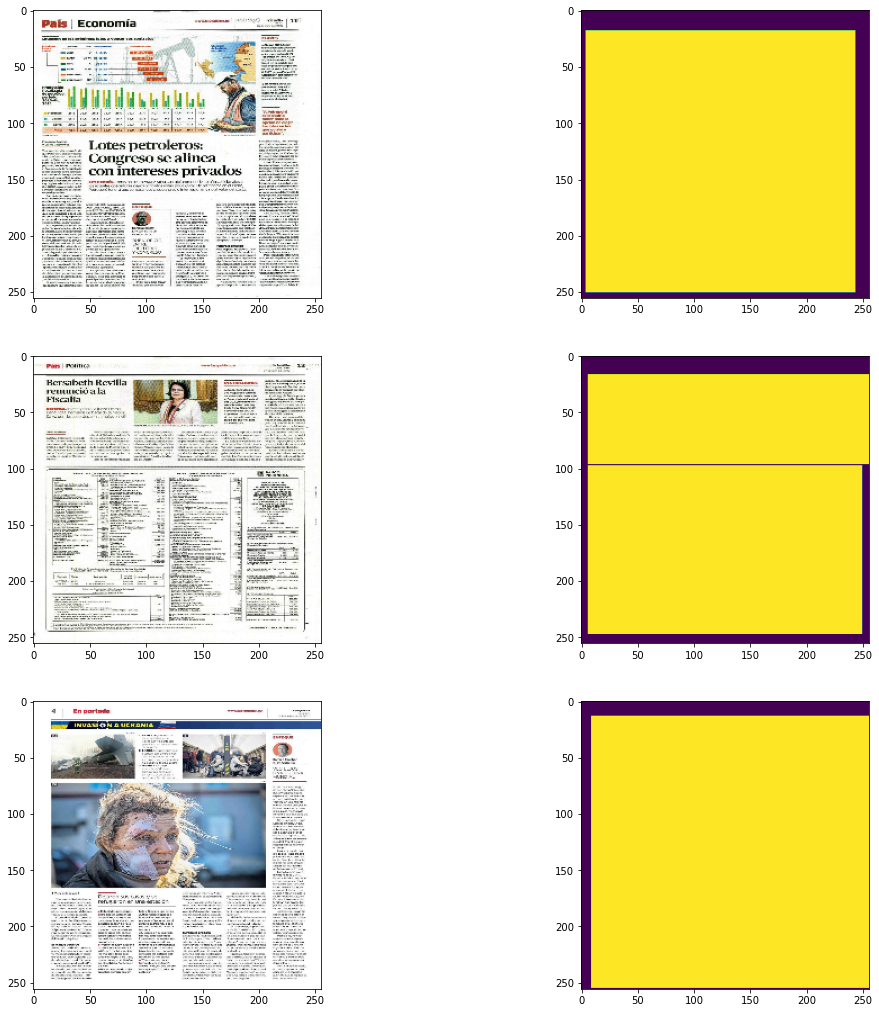

In [19]:
# PRINT V2

for img,mask in train_batch:
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [20]:
# unique values of mask1, mask2, mask3
print(np.unique(mask1))
print(np.unique(mask2))
print(np.unique(mask3))

[0 4]
[0 2]
[0 7]


# Arquitectura

In [6]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)  

class unet_model(nn.Module):
    def __init__(self,out_channels=11,features=[32, 64, 128, 256]): # features=[64, 128, 256, 512]): 
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

# Test

In [3]:
DEVICE = f'cuda:{3}' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:3'

In [4]:
def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()
    print("Total memory allocated by tensors on GPU:", torch.cuda.memory_allocated())
    print("Total memory reserved by CUDA on GPU:", torch.cuda.memory_reserved())
clean_memory()

Total memory allocated by tensors on GPU: 0
Total memory reserved by CUDA on GPU: 0


In [7]:
print(unet_model())

unet_model(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv1): encoding_block(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): encoding_block(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [8]:
model = unet_model().to(DEVICE)
summary(model, (3, 256, 256))

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:
LEARNING_RATE = 1e-4
num_epochs = 10

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

## Entrenamiento

In [32]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]


AssertionError: No inf checks were recorded for this optimizer.

In [ ]:
# save model
#torch.save(model.state_dict(), 'unet.pth')

In [ ]:
# load model
#model = unet_model().to(DEVICE)
#model.load_state_dict(torch.load('unet.pth'))
#model.eval()

## Metricas

### Jaccard, Confusion Matrix ...

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [ ]:
check_accuracy(train_batch, model)

In [ ]:
check_accuracy(test_batch, model)

In [ ]:
for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = y[0,:,:].permute(1, 2, 0)
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = y[1,:,:].permute(1, 2, 0)
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = y[2,:,:].permute(1, 2, 0)
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break